In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns

import csv

# Clean Dataset

The data that is used in this project is the yelp dataset. We only selected boba shops for the business dataset and concatenated it with the reviews for each given business.

In [2]:
df = pd.read_csv("yelp_reviews_boba_categories.csv")
#Created a new column called sentiment to group positive, negative and neutral 
df.loc[(df["stars"] >= 4, "Sentiment")] = 'Positive'
df.loc[(df["stars"] == 3, "Sentiment")] = 'Neutral'
df.loc[(df["stars"] == 3.5, "Sentiment")] = 'Neutral'
df.loc[(df["stars"] <= 2.5, "Sentiment")] = 'Negative'
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date,Sentiment
0,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",79nOboO-4_yNuQQ21EAU1A,5,Extremely Nice and clean I go there everyday l...,2021-05-18 22:04:32,Positive
1,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",CSBRNusUV3D8t192J-W1yA,3,This experience was a little underwhelming. I...,2021-06-08 02:05:36,Positive
2,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",Xc9cAaAlshYfBKOZXg2THA,5,Amazing. Refreshing drinks. There's a shortage...,2021-06-10 19:11:25,Positive
3,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",R8kA79smxR1cy22U5ZQ56w,4,At first I questioned why there was another KF...,2021-05-18 19:18:18,Positive
4,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",bhAB5wo9iLsaExSw4apR4g,4,This is the second Kung Fu tea that has sprung...,2021-07-30 00:24:33,Positive


In [3]:
print(len(df.business_id.unique())) #Prints how many businesses are in the clean dataset

153


# EDA for the Clean Dataset

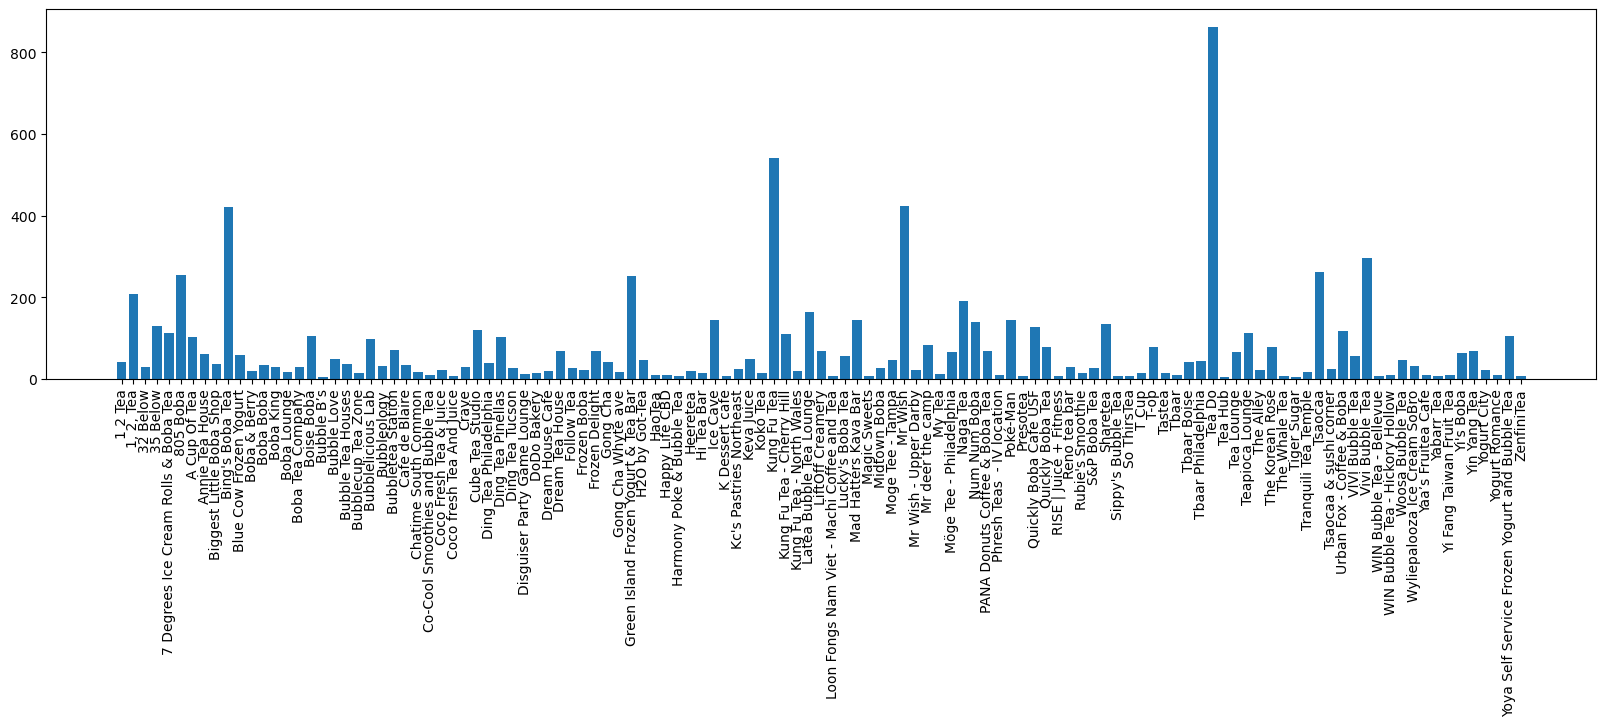

In [4]:
#Total number of reviews for each restaurant
reviewsCount = df.groupby("name")["stars"].count()
plt.figure().set_figwidth(20)
plt.bar(reviewsCount.index,reviewsCount)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:ylabel='Review Ratings'>

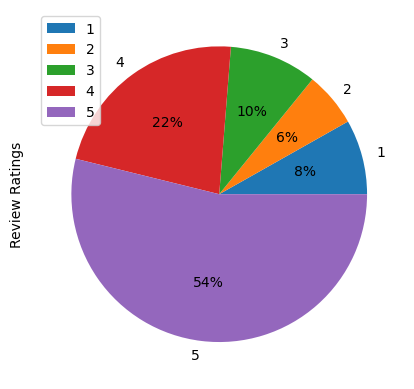

In [5]:
#Distribution of star ratings in dataframe
df.groupby(['review_stars']).count().plot(kind='pie', y='text', ylabel="Review Ratings", autopct='%1.0f%%')

In [6]:
#for i in range(len(df.attributes)):
print(len(df.attributes))
df['attributes'] = df['attributes'].astype(str)
df.head(50)

8581


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date,Sentiment
0,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",79nOboO-4_yNuQQ21EAU1A,5,Extremely Nice and clean I go there everyday l...,2021-05-18 22:04:32,Positive
1,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",CSBRNusUV3D8t192J-W1yA,3,This experience was a little underwhelming. I...,2021-06-08 02:05:36,Positive
2,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",Xc9cAaAlshYfBKOZXg2THA,5,Amazing. Refreshing drinks. There's a shortage...,2021-06-10 19:11:25,Positive
3,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",R8kA79smxR1cy22U5ZQ56w,4,At first I questioned why there was another KF...,2021-05-18 19:18:18,Positive
4,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",bhAB5wo9iLsaExSw4apR4g,4,This is the second Kung Fu tea that has sprung...,2021-07-30 00:24:33,Positive
5,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",0MJ5sKX5uq7Ma5hbl4l3BQ,4,Decent..by Brace Rd but only one cashier & was...,2021-10-31 23:30:14,Positive
6,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",8B4Q5yZar2XTdfAzu04WUQ,4,"The chicken is super crispy, and if you like a...",2021-08-11 08:05:24,Positive
7,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",MfuE21un_E9mPO3UG26PoQ,5,Drinks and food are fantastic. Staff is very f...,2021-06-11 04:19:02,Positive
8,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",K1tiI9gz4KRBqgr_A5v5oQ,5,Service and food are great at this location......,2021-06-09 16:07:37,Positive
9,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",tHVFAI0kemjV8Il9UjXBrw,5,This is the new Kung Fu Tea location that just...,2021-12-31 21:55:57,Positive


This graph shows the relationship between the cost of Wi-Fi and the star rating given by the user. We can see that since there are more lower ratings when Wi-Fi is not free that there could be a relationship between cost of Wi-Fi and the star rating given by the user.

<AxesSubplot:xlabel='wifi', ylabel='stars'>

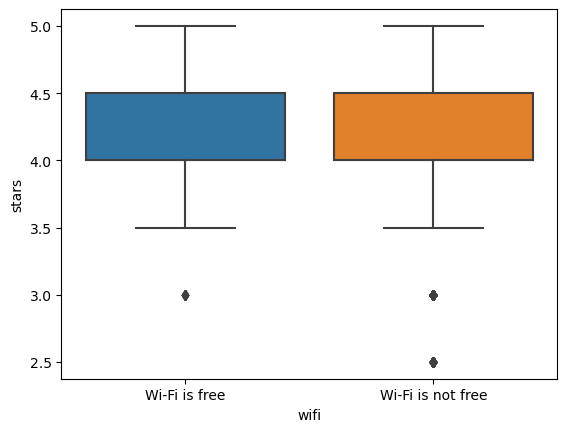

In [7]:
for i in range(len(df.attributes)):
    if df.attributes[i][12:16] == 'free':
        df.loc[i,'wifi'] = "Wi-Fi is free"
    else:
        df.loc[i,'wifi'] = "Wi-Fi is not free"
sns.boxplot(x='wifi', y='stars', data=df)

In [8]:
for i in range(len(df.attributes)):
    if "'RestaurantsTakeOut': 'True'" in df.attributes[i]:
        df.loc[i,'take-out'] = "Yes"
    else:
        df.loc[i,'take-out'] = "No"

This graph shows the relationship between restaurant take-out and the star rating given by the user. We can see that most of the restaurants have take-out and have significantly good ratings given by user. The restaurants that don't have take-out also have similar distribution. Therefore, restaurant take-out does not have much effect on the star rating given by the user. 

<AxesSubplot:ylabel='take-out'>

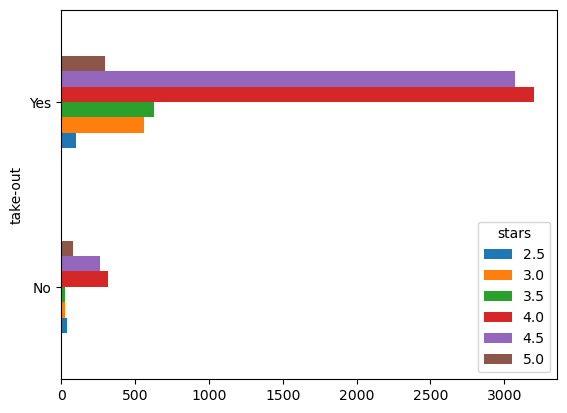

In [9]:
df2 = df.groupby(['take-out','stars']).size()
df2 = df2.unstack()
df2.plot(kind="barh")

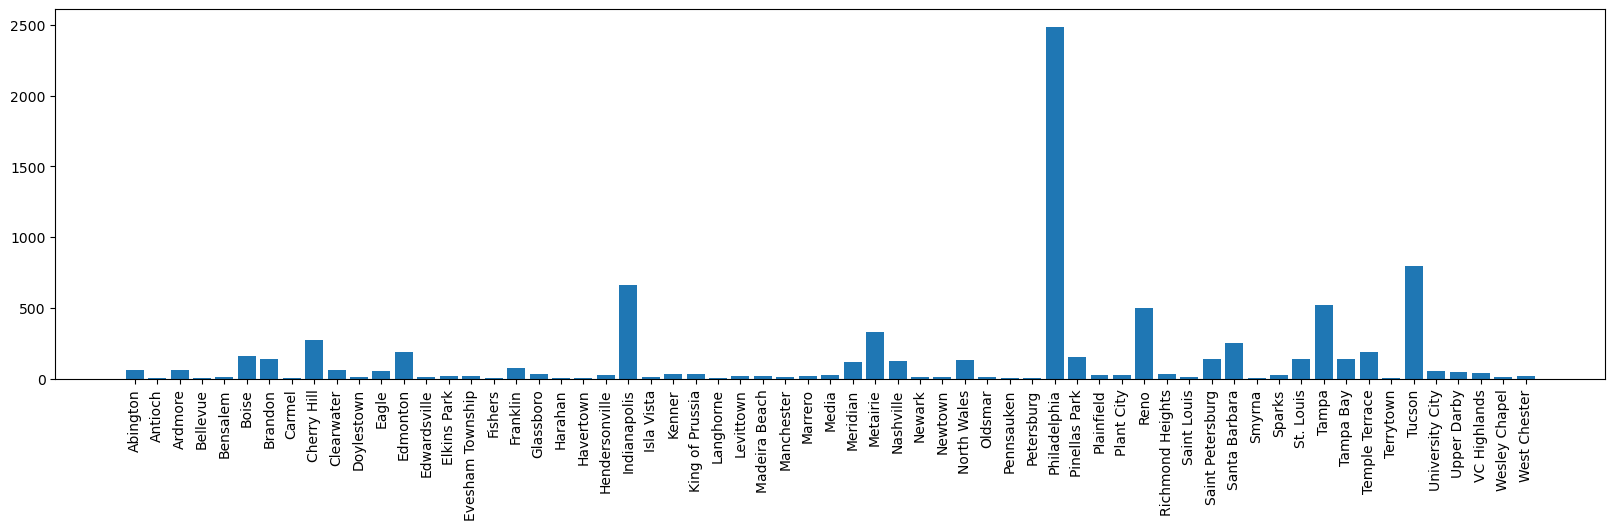

In [10]:
reviewsCount = df.groupby("city")["stars"].count()
plt.figure().set_figwidth(20)
plt.bar(reviewsCount.index,reviewsCount)
plt.xticks(rotation=90)
plt.show()

The bar graph shows the distribution of places with boba on yelp based on cities in the data set.

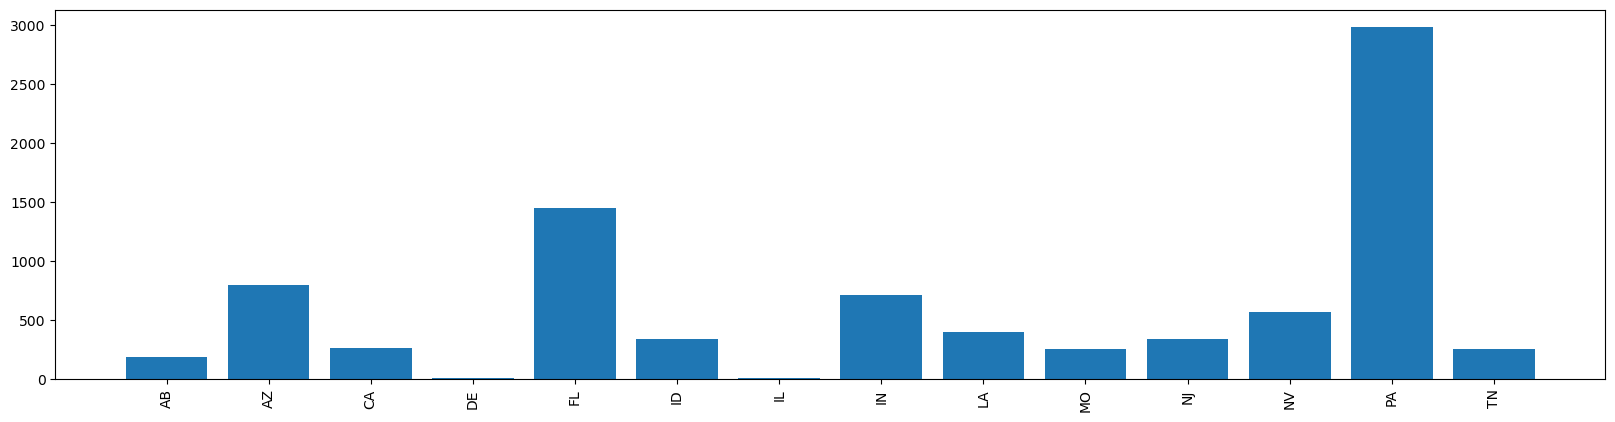

In [11]:
reviewsCount = df.groupby("state")["stars"].count()
plt.figure().set_figwidth(20)
plt.bar(reviewsCount.index,reviewsCount)
plt.xticks(rotation=90)
plt.show()

The bar graph shows the distribution of places with boba on yelp based on states in the data set.

<AxesSubplot:ylabel='Review Stars'>

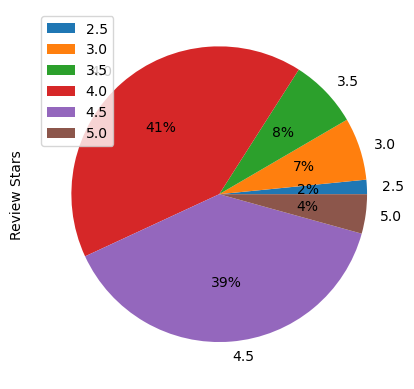

In [12]:
df.groupby(['stars']).count().plot(kind='pie', y='text', ylabel="Review Stars", autopct='%1.0f%%')

These is the distribution of review stars rounded to the half-stars.

/Users/arlenephimmasone/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


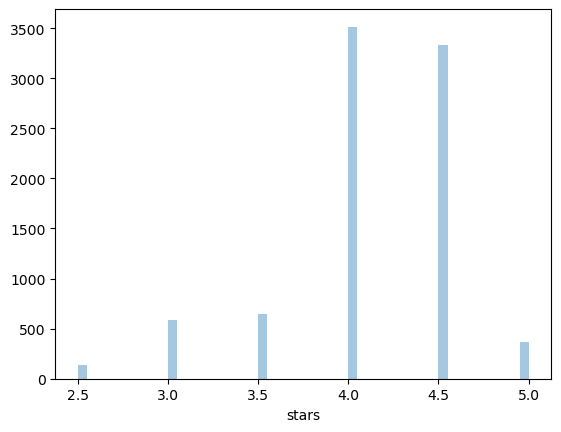

In [13]:
sns.distplot(df['stars'], kde=False); #distribution of stars

This visualization shows the average amount of stars across all boba businesses. 

# Text Mining with Linear Regression

Using linear regression, we are trying to predict whether a review is negative or positive and what rating the user will give for that business. 

In [14]:
#natural language toolkit
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [16]:
#displaying a dataframe that only contains the reviews, sentiment, and star ratings
display(df[['text', 'Sentiment','stars']])

,text,Sentiment,stars
0,Extremely Nice and clean I go there everyday l...,Positive,4.5
1,This experience was a little underwhelming. I...,Positive,4.5
2,Amazing. Refreshing drinks. There's a shortage...,Positive,4.5
3,At first I questioned why there was another KF...,Positive,4.5
4,This is the second Kung Fu tea that has sprung...,Positive,4.5
...,...,...,...
8576,Super delicious! They have unique flavors here...,Positive,4.5
8577,Good quality of tea and some unique options. S...,Positive,4.5
8578,"AMAZING,\n\n\n\nthats all i can say\nIf you go...",Positive,4.5
8579,"Good tea, interesting milk foam. I wish it wou...",Positive,4.5


In [17]:
#length of each review, made new length column at end to see num of charcaters in review
df['length'] = df['text'].apply(len)
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date,Sentiment,wifi,take-out,length
0,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",79nOboO-4_yNuQQ21EAU1A,5,Extremely Nice and clean I go there everyday l...,2021-05-18 22:04:32,Positive,Wi-Fi is free,Yes,102
1,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",CSBRNusUV3D8t192J-W1yA,3,This experience was a little underwhelming. I...,2021-06-08 02:05:36,Positive,Wi-Fi is free,Yes,468
2,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",Xc9cAaAlshYfBKOZXg2THA,5,Amazing. Refreshing drinks. There's a shortage...,2021-06-10 19:11:25,Positive,Wi-Fi is free,Yes,111
3,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",R8kA79smxR1cy22U5ZQ56w,4,At first I questioned why there was another KF...,2021-05-18 19:18:18,Positive,Wi-Fi is free,Yes,1120
4,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",bhAB5wo9iLsaExSw4apR4g,4,This is the second Kung Fu tea that has sprung...,2021-07-30 00:24:33,Positive,Wi-Fi is free,Yes,394


<AxesSubplot:xlabel='stars', ylabel='length'>

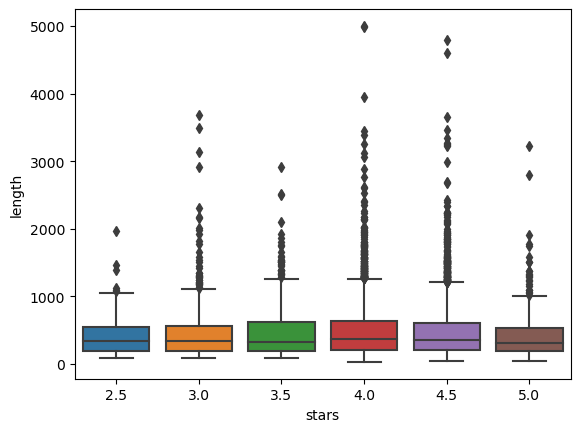

In [18]:
#visualize length of review vs star number rating
sns.boxplot(x='stars', y='length', data=df)

The above boxlpot shows the visualization of length of characters in a review vs the respective star rating. We can see that shorter lengthed reviews tend to have a lower star rating compared to higher star rated reviews. However, this might be because there are less negative ratings.

In [19]:
import nltk
from nltk.corpus import stopwords

full_text = ' '.join(df['text'])
#convert reviews to lowercase
lower_full_text = full_text.lower()
#tokenize words and put into a list
word_tokens = word_tokenize(lower_full_text)
tokens = list()

#if the word is a character and is not a stop word, append to list, then find freq of tokens
for word in word_tokens:
    if word.isalpha() and word not in stopwords.words('english'):
        tokens.append(word)
token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(30),columns=['Word', 'Frequency'])

In [20]:
#distribution of frequent unique words in reviews
print(dist)

          Word  Frequency
0          tea      13745
1         boba       7851
2        place       5806
3         milk       5047
4         good       3707
5       drinks       3508
6         like       3474
7       bubble       3379
8        drink       3348
9        great       2628
10         get       2607
11        time       2400
12         one       2392
13        also       2366
14      really       2273
15        love       2129
16         ice       2122
17         got       2116
18         try       2045
19       sweet       2042
20        back       1982
21       would       1922
22          go       1783
23     service       1684
24        nice       1673
25  definitely       1628
26       sugar       1587
27       order       1545
28        teas       1544
29      always       1499


In [21]:
#new df with only stars, type of review, and reviews
starsdf = pd.DataFrame(df[['stars','Sentiment','text']])
starsdf.head()

,stars,Sentiment,text
0,4.5,Positive,Extremely Nice and clean I go there everyday l...
1,4.5,Positive,This experience was a little underwhelming. I...
2,4.5,Positive,Amazing. Refreshing drinks. There's a shortage...
3,4.5,Positive,At first I questioned why there was another KF...
4,4.5,Positive,This is the second Kung Fu tea that has sprung...


In [22]:
#categorical to numerical data for sentinent
starsdf['Sentiment'].replace(['Negative', 'Positive', 'Neutral'],
                        [2, 1, 0], inplace=True)
starsdf.head()

,stars,Sentiment,text
0,4.5,1,Extremely Nice and clean I go there everyday l...
1,4.5,1,This experience was a little underwhelming. I...
2,4.5,1,Amazing. Refreshing drinks. There's a shortage...
3,4.5,1,At first I questioned why there was another KF...
4,4.5,1,This is the second Kung Fu tea that has sprung...


In [23]:
#analyze each sentiment (pos(1), neutral(0), neg(2))
print('Number of positive reviews: ', starsdf['Sentiment'].value_counts()[1])
print('Number of negative reviews: ', starsdf['Sentiment'].value_counts()[2])
print('Number of neutral reviews: ', starsdf['Sentiment'].value_counts()[0])

Number of positive reviews:  7212
Number of negative reviews:  135
Number of neutral reviews:  1234


In [24]:
#7212 rows = 7212 positive reviews, as seen from above
#make df with only positive reviews
pos = starsdf.loc[starsdf['Sentiment'] == 1]
posrev = pd.DataFrame(pos[['stars','Sentiment','text']])
len(pos.index)

7212

In [25]:
#make df with only neutral reviews
neu = starsdf.loc[starsdf['Sentiment'] == 0]
neurev = pd.DataFrame(neu[['stars','Sentiment','text']])
len(neu.index)

1234

In [26]:
#make df with only negative reviews
neg = starsdf.loc[starsdf['Sentiment'] == 2]
negrev = pd.DataFrame(neg[['stars','Sentiment','text']])
len(neg.index)

135

In [27]:
#df with positive and negative reviews
posneg = starsdf.loc[(starsdf['Sentiment'] == 1) | (starsdf['Sentiment'] == 2)]
posnegrev = pd.DataFrame(posneg[['stars','Sentiment','text']])
len(posneg.index)

7347

We will be using the dataframe above to decipher between strictly positive and negative reviews when testing

In [28]:
#data classification
X = posneg['text']
y = posneg['stars']

In [29]:
#remove punctuation in reviews
def rm(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [30]:
#word freq in pos reviews
full_text = ' '.join(pos['text'])
#convert reviews to lowercase
lower_full_text = full_text.lower()
#tokenize words and put into a list
word_tokens = word_tokenize(lower_full_text)
tokens = list()

#if the word is a character and is not a stop word, append to list, then find freq of tokens
for word in word_tokens:
    if word.isalpha() and word not in stopwords.words('english'):
        tokens.append(word)
token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(10),columns=['Word', 'Frequency'])
print(dist)

     Word  Frequency
0     tea      12125
1    boba       6344
2   place       5016
3    milk       4361
4    good       3165
5  bubble       2992
6  drinks       2976
7    like       2902
8   drink       2729
9   great       2290


The above table shows the first 10 most common words used in positive reviews

In [31]:
testReview = CountVectorizer(analyzer=rm).fit(X)

Below we are testing a random review. First, we see the size of the review is 17734 characters. Then the review is vectorized and we see that transform is used so that it goes through each word in the review to see how many unique words there are.

In [32]:
#testing random review, review as a vector (another way for BOW)
#size of review
print(len(testReview.vocabulary_))
rev43 = X[43]
print(rev43)
test1 = testReview.transform([rev43])
print(test1)

17734
Decided to try this place out since how often are there new boba places opening in Reno?

I ordered the Hokkaido milk tea with boba. The drink itself was very very sweet. Hokkaido milk teas tend to be sweet, but it was almost overpowering. Despite it being too sweet, you could still taste the tea flavor. The boba itself was only ok. It was a little clumpy. I'm pretty confident I just ordered the wrong drink for me, so I'll definitely be coming back to try this place out again. 

The staff are all very friendly and helpful. The interior is cute and has a nice sitting area. They also sell some really delicious snacks.
  (0, 1581)	1
  (0, 1619)	1
  (0, 2363)	2
  (0, 2470)	1
  (0, 2471)	1
  (0, 3889)	1
  (0, 5510)	1
  (0, 5519)	1
  (0, 5702)	1
  (0, 5899)	1
  (0, 6274)	3
  (0, 7164)	1
  (0, 7275)	1
  (0, 7402)	1
  (0, 7583)	1
  (0, 7847)	1
  (0, 8023)	1
  (0, 8050)	1
  (0, 8504)	2
  (0, 9313)	1
  (0, 9554)	1
  (0, 10209)	1
  (0, 10792)	1
  (0, 11373)	1
  (0, 11880)	2
  (0, 12274)	1
 

In [33]:
#words that are most common, in this review we can read that the drinks are sweet
print(testReview.get_feature_names_out()[8504])
print(testReview.get_feature_names_out()[15955])

drink
sweet


Here we are transforming data X into sparse matrix to speed up processing since there are many zero occurences:

In [ ]:
X = testReview.transform(X)
#shape of the matrix:
print("Shape of the sparse matrix: ", X.shape)
#non-zero occurences:
print("Non-Zero occurences: ",X.nnz)

#new density of matrix
density = (X.nnz/(X.shape[0]*X.shape[1]))*100
print("Density of the matrix = ",density)

In [ ]:
# vectorization
vect = CountVectorizer(stop_words=stopwords.words('english'))
vect.fit(posneg.text)
X = vect.transform(posneg.text)
X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())

# define the vector of targets 
# matrix of features
y = posneg.Sentiment
X = X_df
# # Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
#k nearest neighbor
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
predknn = knn.predict(X_test)
print("Confusion Matrix for K Nearest Neighbors:")
print(confusion_matrix(y_test,predknn))
print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
print("Classification Report:")
print(classification_report(y_test,predknn))

Above are the confusion matrix and accuracy score for K nearest neighbors, we can see that the score has an accuracy of 98.14% which is high. We will use test this to predict whether a review is positive or negative.

Below we are predicting a positive or negative review using KNN. The review below is positive. 

In [ ]:
posrev = posneg['text'][0]
print("Positive review: ", posrev)
print("Star Rating: ", posneg['stars'][0])
posrev_t = vect.transform([posrev])
knn.predict(posrev_t)

#look at first number
#1 = positive, 2 = negative
print("Predicted Pos/Neg Rating (second column):")
print(posrev_t)

Below we are predicting a positive or negative review using KNN. The review below is negative.

In [ ]:
negrev = posneg['text'][562]
print("Negative review: ", negrev)
print("Star Rating: ", neg['stars'][562])
negrev_t = vect.transform([negrev])
knn.predict(negrev_t)

#look at first number
#1 = positive, 2 = negative
print("Predicted Pos/Neg Rating (second column):")
print(negrev_t)